In [1]:
!nvidia-smi

Mon Jun  1 06:09:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd drive/My\ Drive/Projects/Anomaly_Detection_Time_Series

/content/drive/My Drive/Projects/Anomaly_Detection_Time_Series


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [5]:
import tensorflow as tf
from nbeats_model import NBeatsNet

Using TensorFlow backend.


In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

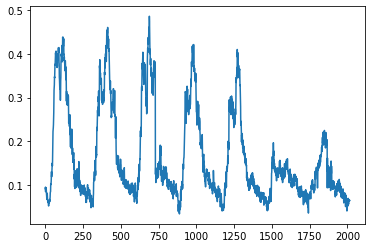

In [8]:
plt.plot(df[:288*7])

In [0]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [0]:
class Args:
  def __init__(self):
    self.val_start = 12*24*250
    self.test_start = 12*24*300
    #self.train_seq_len = 12*24*7
    self.val_seq_len = 12*24
    
    self.seasonality = 12*24
    self.batch_size = 512
    self.num_epochs = 100
    self.hidden_dim = 100
    self.theta_1 = 288*7
    self.theta_2 = 288*7
    self.nb_blocks_per_stack = 20
    
    self.save_folder = 'NBEATS_weekday_weekend_combined_with_OHE'

In [0]:
args = Args()

In [0]:
os.makedirs('forecasts/', exist_ok=True)
os.makedirs('forecasts/' + args.save_folder, exist_ok=True)

In [0]:
train_df = df[: args.val_start]
val_df = df[args.val_start: args.test_start]
test_df = df[args.test_start:]

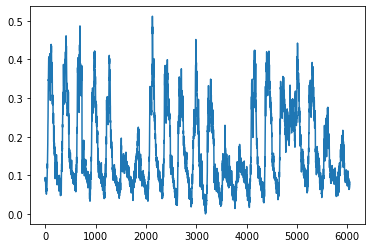

In [14]:
plt.plot(train_df[:288*21])

In [0]:
def make_windows(data, train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data.values[i - train_seq_len: i].T.tolist())
        y.append(data.values[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [0]:
#sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4)
#loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [0]:
def run(train_seq_len):
  data = np.load('saved_arrays/train_val_test_{}.npz'.format(train_seq_len))
  X_train = data['X_train']
  y_train = data['y_train']
  X_val = data['X_val']
  y_val = data['y_val']
  X_test = data['X_test']
  y_test = data['y_test']

  model = NBeatsNet(backcast_length = train_seq_len, forecast_length = args.val_seq_len,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=args.nb_blocks_per_stack,
                  thetas_dim = (args.theta_1, args.theta_2), share_weights_in_stack = True, hidden_layer_units = args.hidden_dim)
          
  model.compile_model(loss='mse', learning_rate = 0.001)

  history = model.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

  y_pred = model.predict(X_test)
  y_pred = y_pred.squeeze()
  y_test = y_test.squeeze()

  plt.plot(y_test[12*24*2], color = 'blue')
  plt.plot(y_pred[12*24*2], color = 'red')
  plt.show()
  plt.close()

  if not os.path.exists('forecasts/optimal_lag.csv'):
    results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2'])  
  else:
    results = po.read_csv('forecasts/optimal_lag.csv')

  errors = {'model': args.save_folder,
            'lag': train_seq_len, 
            'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
            'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
            'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
            'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
            'R2': r2_score(y_true=y_test, y_pred=y_pred)          
            }

  errors = po.Series(errors)
  results = results.append(errors, ignore_index=True)
  print(results)
  results.to_csv('forecasts/optimal_lag.csv', index=False)

  del X_train, y_train, X_val, y_val, X_test, y_test
  #%reset_selective X_train 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 2016, 1)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2016)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 100)          201700      lambda_1[0][0]                   
                                                                 subtract_1[0][0]                 
                                                                 subtract_2[0][0]                 
                                                                 subtract_3[0][0]           

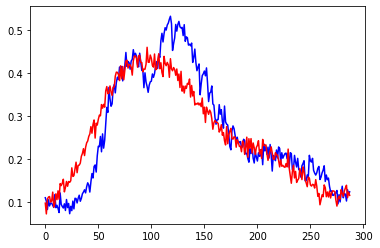

                                      model       MAE  ...      RMSE     lag
0  NBEATS_weekday_weekend_combined_with_OHE  0.041293  ...  0.054418  2016.0
1  NBEATS_weekday_weekend_combined_with_OHE  0.040196  ...  0.054562  2016.0

[2 rows x 7 columns]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 4032, 1)      0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4032)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 100)          403300      lambda_2[0][0]                   
                                     

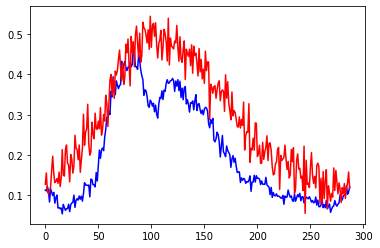

                                      model       MAE  ...      RMSE     lag
0  NBEATS_weekday_weekend_combined_with_OHE  0.041293  ...  0.054418  2016.0
1  NBEATS_weekday_weekend_combined_with_OHE  0.040196  ...  0.054562  2016.0
2  NBEATS_weekday_weekend_combined_with_OHE  0.048603  ...  0.062552  4032.0

[3 rows x 7 columns]
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 6048, 1)      0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 6048)         0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 100)          604900

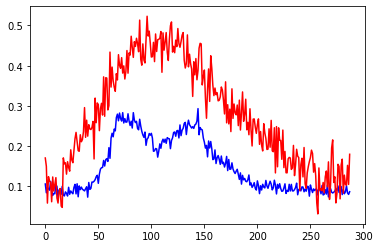

                                      model       MAE  ...      RMSE     lag
0  NBEATS_weekday_weekend_combined_with_OHE  0.041293  ...  0.054418  2016.0
1  NBEATS_weekday_weekend_combined_with_OHE  0.040196  ...  0.054562  2016.0
2  NBEATS_weekday_weekend_combined_with_OHE  0.048603  ...  0.062552  4032.0
3  NBEATS_weekday_weekend_combined_with_OHE  0.053972  ...  0.069352  6048.0

[4 rows x 7 columns]


In [18]:
for lag in list(range(7*288, (21+1)*288, 7*288)):
  run(lag)

In [0]:
results = po.read_csv('forecasts/optimal_lag.csv')

In [25]:
results

,model,MAE,MSE,R2,MAPE,RMSE,lag
0,NBEATS_weekday_weekend_combined_with_OHE,0.040196,0.002977,0.696922,4.019639,0.054562,2016.0
1,NBEATS_weekday_weekend_combined_with_OHE,0.048603,0.003913,0.525401,4.860335,0.062552,4032.0
2,NBEATS_weekday_weekend_combined_with_OHE,0.053972,0.004810,0.314029,5.397238,0.069352,6048.0


In [0]:
results = results.drop(index = [0])

In [0]:
results.to_csv('forecasts/optimal_lag.csv', index=False)